## Experiment 2: Quark Gluon
- 20000 samples
- Train pairs: (36000, 2, 40, 40)
- Test pairs:  (4000, 2, 40, 40)
- using only 1 channel
- Data: cropping, normalisation, pair creation
- Model: Resnet
- Loss: contrastive margin pair loss
- Siamese Network
- Training epochs 20, batch size 1800, loss: 0.2 approx

### Imports and Data loading

In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, initializers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = np.load('../../data/quark_gluon_dataset/qg_20000_pairs_c1.npz', allow_pickle=True)

pairs_train = data["pairs_train"]
labels_train = data["labels_train"]
pairs_test = data["pairs_test"]
labels_test = data["labels_test"]

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape, labels_test.shape)

(36000, 2, 40, 40) (4000, 2, 40, 40)
(36000,) (4000,)


In [3]:
pairs_train = np.expand_dims(pairs_train, -1)
pairs_test = np.expand_dims(pairs_test, -1)
print(pairs_train.shape)

(36000, 2, 40, 40, 1)


### Model

In [11]:
from resnet import resnet18

In [17]:
# Contrastive Pair loss
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

# Siamese Network model
def create_siamese_network(input_shape, resnet_model):
    # base_model = create_quantum_cnn(resnet_model, return_embeddings=True)
    base_model = resnet_model

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])


    siamese_model = models.Model([input_0, input_1], distance)

    return siamese_model, base_model

### Training

In [18]:
# Training
tf.get_logger().setLevel('ERROR')

# checkpoint_path = "hybrid_cnn_base_1_ep/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='hybrid_model_qg1.h5', save_weights_only=True,verbose=1)


input_shape = pairs_train.shape[2:]
resnet_base_model, renet_embedding_model = resnet18(input_shape=input_shape)
siamese_network, base_model = create_siamese_network(input_shape, resnet_base_model)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(learning_rate=1e-3))

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=20,
    batch_size=1800,
    callbacks=[cp_callback]
)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 29.4596 
Epoch 1: saving model to hybrid_model_qg1.h5
20/20 [==============================] - 339s 17s/step - loss: 29.4596 - val_loss: 0.4859
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.8303  
Epoch 2: saving model to hybrid_model_qg1.h5
20/20 [==============================] - 1544s 77s/step - loss: 0.8303 - val_loss: 0.4869
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.4070  
Epoch 3: saving model to hybrid_model_qg1.h5
20/20 [==============================] - 1414s 70s/step - loss: 0.4070 - val_loss: 0.4856
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.3264  
Epoch 4: saving model to hybrid_model_qg1.h5
20/20 [==============================] - 1529s 77s/step - loss: 0.3264 - val_loss: 0.4808
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 0.3008 
Epoch 5: saving model to hybrid_model_qg1.h5
20/20 [========================

In [19]:
siamese_network.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 model_8 (Functional)        (None, 512)                  1144729   ['input_8[0][0]',             
                                                          6          'input_9[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['model_8[0][0]',      

In [20]:
d = np.load('../../data/quark_gluon_dataset/quark_gluon_20000_1.npz', allow_pickle=True)
x_train = d["x_train"]
y_train = d["y_train"]
x_test = d["x_test"]
y_test = d["y_test"]

<Axes: title={'center': 'Learning History'}>

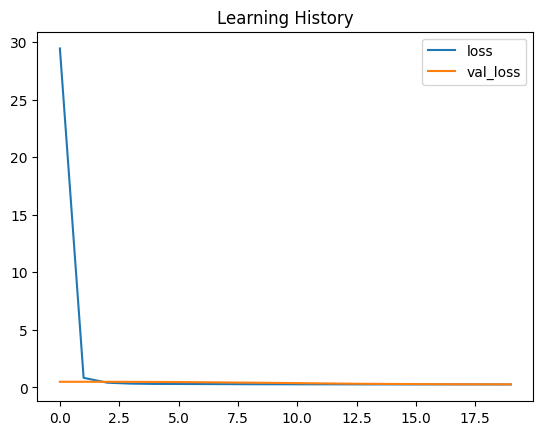

In [21]:
pd.DataFrame(history.history).plot(title="Learning History")

### Embeddings

In [22]:
embedding_model = models.Model(inputs=base_model.input, outputs=base_model.output)

# Use the model to predict (get embeddings) for new data
embeddings = embedding_model.predict(x_test[:,:,:,0])

# Example: fetching embeddings for the training data
print(embeddings.shape)

63/63 [==============================] - 5s 68ms/step
(2000, 512)


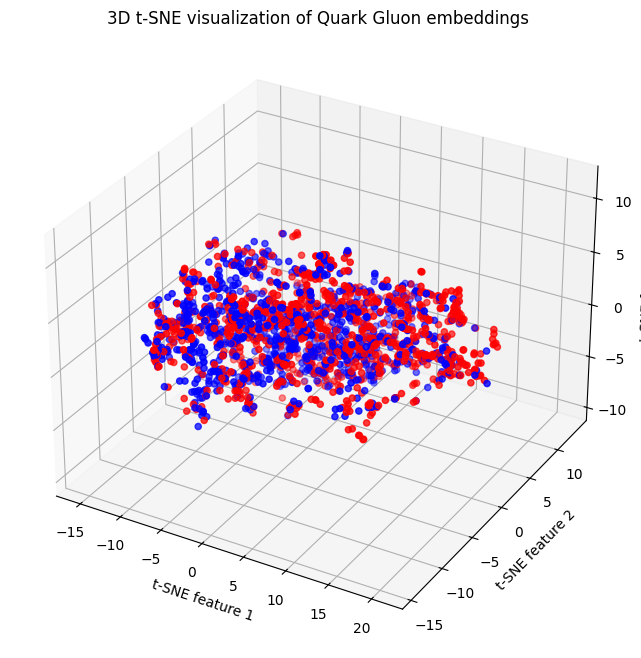

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

df = pd.DataFrame(embeddings_3d, columns=['tsne1', 'tsne2', 'tsne3'])
df['label'] = y_test

# Visualize the 3D embeddings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if label == 1 else 'blue' for label in y_test]
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors)
ax.set_title('3D t-SNE visualization of Quark Gluon embeddings')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
plt.show()

### Model Evaluation

In [24]:
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

y_pred = distances_to_labels(distance)

125/125 [==============================] - 13s 102ms/step


In [25]:
from helpers import evaluate_precision_recall_accuracy
evaluate_precision_recall_accuracy(labels_test,y_pred)

(0.512428870919437, 0.8555, 0.52075)

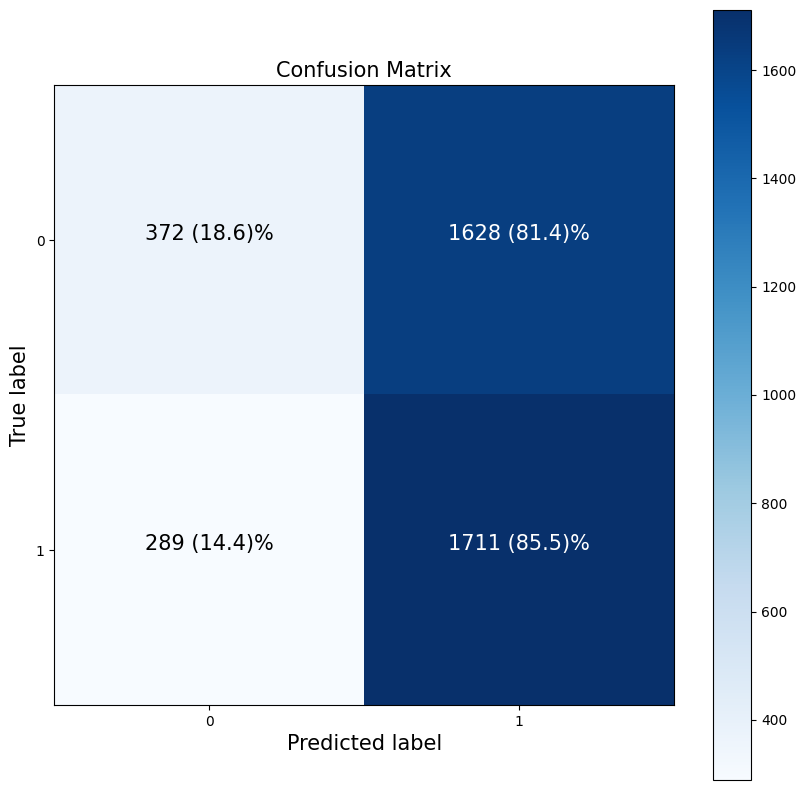

In [26]:
from helpers import make_cm
make_cm(labels_test,y_pred)

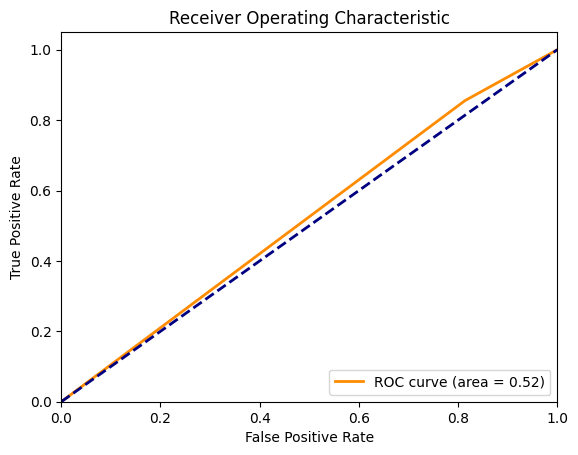

In [27]:
from helpers import plot_auc
plot_auc(labels_test,y_pred)